# Como resolver problemas envolvendo Processamento de Linguagem Natural (Natural Language Processing) utilizando Aprendizado de Máquina (Machine Learning).

Dados textuais estão em toda parte e você como empresa ou alguém que esteja trabalhando para lançar um novo produto, pode utizá-los para validar, melhorar e expandir esses produtos. A ciência que extrai significado e aprendizado de dados textuais disponíveis no mundo é chamada de Processamento de Linguagem Natural (NLP).

NLP produz novos e incríveis resultados diariamente. Além disso, vem sendo estudada e praticada em grande escala. No entanto, a maior parte dos problemas, e não menos importantes, são colocados em prática com maior frequência em relação a outros:

    - Identificar diferentes grupos de usuários/clientes (ex. predizer rotatividade, tempo de vida, preferência de produtos);
    - Detectar e extrair com precisão diferentes categorias de um feedback (ex. reviews positivos e negativos, menções a   determinadas características e atributos);
    - Classificação textual de acordo com uma intenção (ex. se alguém está requisitando ajuda, se está tendo um problema urgente, se uma notícia é falsa ou verdadedaira).
    
Mesmo existindo vários artigos e tutoriais online sobre o tema, é difícil encontrar material e dicas de como tratar problemas que envolvem NLP, de forma eficiente, partindo do zero. Sendo assim, este guia irá auxiliar na construção de soluções que envolvem Aprendizado de Máquina (ML). Depois de acomnpanhar estas orientações, será possível:

    - Coletar, preparar e inspecionar dados;
    - Construir modelos preditivos simples;
    - Interpretar e entender seus modelos, certinfcando-se que ele está aprendendo informações relevantes e não ruído.

Este guia foi construido partindo de uma tradução livre do workshoop disponibilizado por Emmanuel Ameisen em:

https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

# Coletando dados

Todo problema em ML começa com dados, como uma lista de e-mails, postagens em redes sociais ou chats. Algumas fontes são comuns:

    - Revisão de produtos (Amazon, Yelp e App Stores);
    - Contepudo gerado por usuários (Tweets, Facebook e StackOverflow);
    - Solução de problemas (solicitação de clientes, abertura de chamados, informações de bate-papo).
    
Os dados utilizados neste guia, são dados disponibilizados por Figure Eight, chamados de "Disasters on Social Media". Esse conjunto de dados possui mais de 10.000 tweets que foram selecionados a partir de buscas envolvendo chaves como "em chamas", "quarentena" e "pandemônio", relacionando posteriormente o resultado dessas buscas com eventos realmente desastrosos e não-desastrosos.

A tarefa a ser realizada nestes dados é identificar um tweet realmente relevante em relação a um desastre. Uma aplicação em potêncial seria avisar aos bombeiros sobre um desastre que realmente está acontecendo de forma rapidamente, mas contornando uma publicação referente a um filme de ação, que possuem as mesmas palavras chaves.

A seguir a importação das bibliotecas úteis para o desenvolvimento do passo a passo.

In [4]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LogisticRegression

# Limpando os dados

A primeira regra é saber examinar os dados e depois limpá-los. Um conjunmto de dados limpo permitirá que um modelo aprenda apenas recusros signifivamente relevantes e não se adeque a ruídos. Ruídos são características do texto que não são significativos para caracterizar o que se pretende avaliar. No exemplo dos tweets, a hashtag (#) usada para compor determinadas palavras em nada caracteriza o texto propriamente dito. Outras caracterpisticas que precisam ser consideradas na limpeza dos dados são:

    - Remover caracteteres irrelevantes como os não alfanuméricos;
    - Quebrar o seu texto em termos;
    - Remover palavras que não são relevantes, como as menções indicadas com "@";
    - Converter termos para minúsculos, homogeneizando os dados (OLÁ - olá);
    - Combinar palavras escritas incorretamente para uma única representação (legaaalll - legal);
    - Considerar lematização (reduzir palavras como "sou", "é" para uma forma desflexionada como "ser").

Após considerar as opções de limpeza acima, é possível começar a usar os dados para treinar um modelo de predição.

A seguir o código de limpeza dos dados que serão utilizados para treinar o modelo.

In [5]:
# Arquivo de entrada com os dados rotulados
input_file = codecs.open('socialmedia_relevant_cols.csv', 'r', encoding='utf-8', errors='replace')
#Arquivo de saída com os dados rotulados e limpos a serem salvos
output_file = open('socialmedia_relevant_cols_clean.csv', 'w', encoding='utf-8')

#Copiando dados de entrada para os dados de saída
def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [6]:
# Inspecionando os dados
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']

Dados sujos:

In [7]:
#Primeiras linhas
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [8]:
#Últimas linhas
questions.tail()

,text,choose_one,class_label
10808,300K exotic car wrecked in train accident \r\r...,Relevant,1
10809,The twins pitcher's ego is now WRECKED,Not Relevant,0
10810,@Tunes_WGG lol. U got wrecked,Not Relevant,0
10811,you wrecked my whole world,Not Relevant,0
10812,I wrecked my stomach help,Not Relevant,0


In [9]:
# Estatística descritiva dos dados
questions.describe()

,class_label
count,10813.000000
mean,0.431610
std,0.498302
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [10]:
# Expressões regulares para limpeza dos dados
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [11]:
#Limpeza e regravação do arquivo de saída
questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")

clean_questions = pd.read_csv("clean_data.csv")

Dados limpos:

In [12]:
#Primeiras linhas
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label
0,0,just happened a terrible car crash,Relevant,1
1,1,our deeds are the reason of this earthquake m...,Relevant,1
2,2,"heard about earthquake is different cities, s...",Relevant,1
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,4,forest fire near la ronge sask canada,Relevant,1


In [13]:
#Últimas linhas
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10808,10808,300k exotic car wrecked in train accident \r\n,Relevant,1
10809,10809,the twins pitcher's ego is now wrecked,Not Relevant,0
10810,10810,lol u got wrecked,Not Relevant,0
10811,10811,you wrecked my whole world,Not Relevant,0
10812,10812,i wrecked my stomach help,Not Relevant,0


Distribuição das classes:

In [14]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6162,6162,6162
1,4635,4635,4635
2,16,16,16


É possível obervar que os dados são balanceados, com uma leve elevação da classe "Not Relevante".

# Quebrando os dados

Agora que temos os dados limpos, vamos transformá-los para que o modelo possa entender. Logo:

    - Quebrar as sentenças em listas de palavras separadas;
    - Dividir os dados para treinamento e teste do modelo;
    - Inspecionar os dados novamente.

In [15]:
from nltk.tokenize import RegexpTokenizer

# Método de quebra dos dados
tokenizer = RegexpTokenizer(r'\w+')

# Gerando listas de sentenças quebradas
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [16]:
#Primeiras linhas
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [17]:
#Últimas linhas
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label,tokens
10808,10808,300k exotic car wrecked in train accident \r\n,Relevant,1,"[300k, exotic, car, wrecked, in, train, accident]"
10809,10809,the twins pitcher's ego is now wrecked,Not Relevant,0,"[the, twins, pitcher, s, ego, is, now, wrecked]"
10810,10810,lol u got wrecked,Not Relevant,0,"[lol, u, got, wrecked]"
10811,10811,you wrecked my whole world,Not Relevant,0,"[you, wrecked, my, whole, world]"
10812,10812,i wrecked my stomach help,Not Relevant,0,"[i, wrecked, my, stomach, help]"


In [18]:
#Inspecioanndo novamente os dados
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

153895 Quantidade total de palavras, com um vocabulario de 18065
Tamanho máximo de uma sentença 34


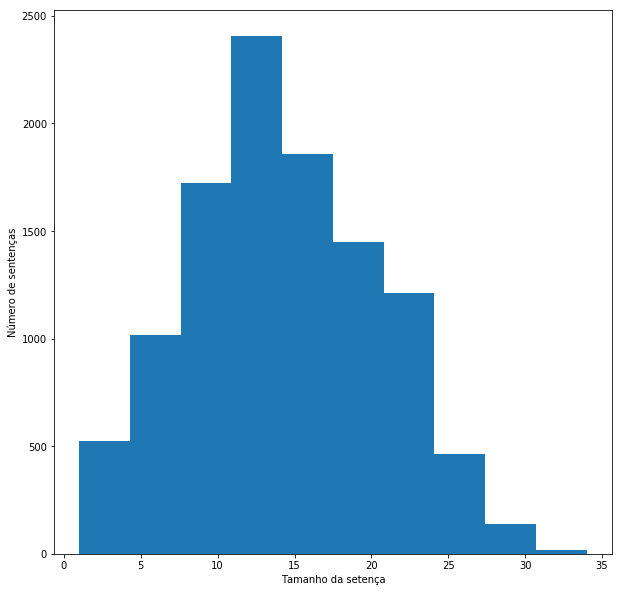

In [19]:
#Distribuilção das sentenças por quantidade de palavras
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
plt.hist(sentence_lengths)
plt.show()

Podemos oberservar que a distribuição no tamanho das sentenças tende a normalidade. Essa característica é importante para evitar viés no processo de classificação quanto ao tamanho dos textos avaliados e a quantidade de palavras específicas em uma determinada sentença.

# Processamento de Linguagem Natural e Aprendizado de Máquina

Agora que nossos dados foram lidos e preparados, vamos mergulhar na parte de aprendizado de máquina e processamento de linguagem natural.

Diferentes problemas em Aprendizagem de Máquina possuem diferentes dados de entrada para que seja possível a realização de previsões. Em imagens podemos usar os pixels brutos como entrada, para detecção de fraude em sistemas podemos usar dados referentes ao acesso de clientes e outros recursos disponíveis.

No Processamento de Linguagem Natural não é diferente, precisamos de dados de entrada para realizar as previsões e, esses dados, são as representações textuais do que se pretende avaliar.

No caso deste guia, iremos utilizar as frases (tweets) que foram coletados nos passos anteriores para realizar as predições.

A abordagem mais simples que podemos utilizar é o modelo de mala de palavras ou, como é mais conhecido, bag-of-words. Uma mala de palavras é uma matriz contento 0 ou 1 para uma palavra em uma determinada setença, em sua abordagem mais simplificada.

Neste guia, usaremos duas abordagens para construção de malas de palavras: Count vectorizer e TF-IDF vectorizer.


# Count vectorizer

In [20]:
# Construindo bag-of-words com count-vectorizer
count_vectorizer = CountVectorizer()

# Separando o texto da variável alvo
list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

# Construindo exemplos para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_counts = count_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_counts = count_vectorizer.transform(X_test)


# Visualizando o Vocabulário

Agora que já criamos o vocabulário para treinar o modelo, vamos tentar identificar algum tipo de estrutura semelhante ou agrupamento baseado na variável alvo. No mundo real perfeito, nosso vocabulário seria tão distinto considerando a variável alvo, que estariam distribuidos perfeitamente em grupos separados. A projeção será feita em duas dimensões (LSA).

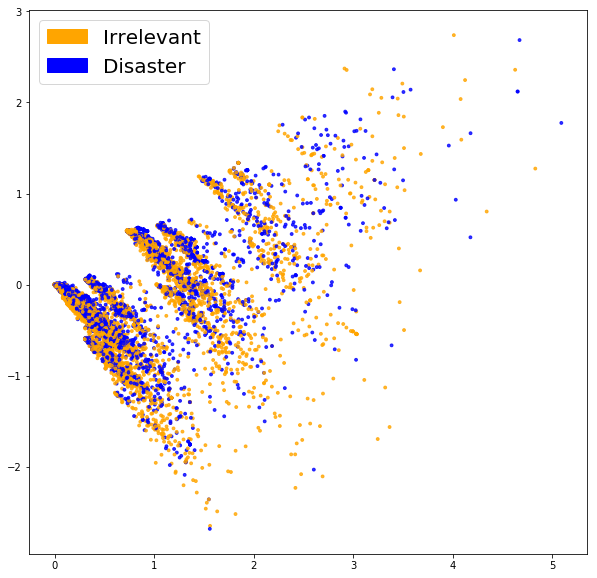

In [25]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
            
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

Nosso vocabulário não parece muito bem separado em grupos distintos de palavras que explicam a variável alvo. No entanto, vamos se é possível construi um modelo útil para lidar com ele.

# Treinando o Classificador

Vamos iniciar com uma regressão logística, visto que, é simples, muiotas vezes resolve o problema e é fácil de interpretar.